In [1]:
from k1lib.imports import *

In [2]:
class Network(nn.Module):
    def __init__(self, hiddenDim=10, hiddenLayers=2, relu=True):
        super().__init__()
        activation = lambda: nn.LeakyReLU() if relu else nn.Sigmoid()
        layers = []
        layers += [nn.Linear(1, hiddenDim), activation()]
        for i in range(hiddenLayers):
            layers += [nn.Linear(hiddenDim, hiddenDim), activation()]
        layers += [nn.Linear(hiddenDim, 1)]
        self.bulk = nn.Sequential(*layers)
    def forward(self, x):
        return self.bulk(x)

In [3]:
def newL(bs=64, optF=None, hiddenLayers=2):
    if optF == None: optF = lambda x: optim.SGD(x, lr=2e-4, momentum=0.9)
    if optF == "Adam": optF = lambda p: optim.Adam(p, lr=1e-2)
    l = k1lib.Learner()
    l.model = Network(hiddenLayers=hiddenLayers)
    l.data = k1lib.data.Data.fromDataset(k1lib.data.FunctionDataset.exp, bs)
    l.opt = optF(l.model.parameters())
    l.lossF = lambda x, y: ((x.squeeze() - y)**2).mean()
    #l.lossF = lambda x, y: (x**2).mean()
    l.cbs.withModifyBatch(lambda x, y: (x[:, None], y))
    l.cbs.withDType(torch.float32);
    def evaluate(self):
        xbs, ybs, ys = self.record(1, 3)
        xbs = torch.vstack(xbs).squeeze()
        ybs = torch.vstack([yb[:, None] for yb in ybs]).squeeze()
        ys = torch.vstack(ys).squeeze()
        #plt.plot(xbs, ybs, ".")
        plt.plot(xbs, ys.detach(), ".")
    l.evaluate = partial(evaluate, l)
    l.cbs.withCancelOnLowLoss(1, epochMode=True)
    return l

In [4]:
hs = [a for a in range(2, 100) for i in range(10)]

In [5]:
ps = []
for h in hs:
    l = newL(optF="Adam", hiddenLayers=h)
    l.cbs.remove("Autosave")
    l.run(50)
    ps.append(l.progress)

Progress:  16%, epoch:  7/50, batch:   24/31, elapsed:   3.59s  Run cancelled: Low loss 1 achieved!.
Progress:  16%, epoch:  7/50, batch:   24/31, elapsed:   3.66s  Run cancelled: Low loss 1 achieved!.
Progress:  10%, epoch:  4/50, batch:   25/31, elapsed:    2.3s  Run cancelled: Low loss 1 achieved!.
Progress:  12%, epoch:  5/50, batch:   28/31, elapsed:   2.75s  Run cancelled: Low loss 1 achieved!.
Progress:  18%, epoch:  8/50, batch:   27/31, elapsed:   4.16s  Run cancelled: Low loss 1 achieved!.
Progress:  27%, epoch: 13/50, batch:   22/31, elapsed:   6.47s  Run cancelled: Low loss 1 achieved!.
Progress:  18%, epoch:  8/50, batch:   27/31, elapsed:    4.0s  Run cancelled: Low loss 1 achieved!.
Progress:  12%, epoch:  5/50, batch:   28/31, elapsed:   2.79s  Run cancelled: Low loss 1 achieved!.
Progress:  12%, epoch:  5/50, batch:   28/31, elapsed:   2.79s  Run cancelled: Low loss 1 achieved!.
Progress:  10%, epoch:  4/50, batch:   25/31, elapsed:   2.29s  Run cancelled: Low loss 1 a

KeyboardInterrupt: 

In [33]:
a = list(np.linspace(hs[0], hs[len(ps)], len(ps)))
with open("data.pth", "wb") as f: pickle.dump(k1lib.Object.fromDict({"hs": a, "ps": ps}), f)

## Analysis

In [35]:
with open("data.pth", "rb") as f: data = pickle.load(f)

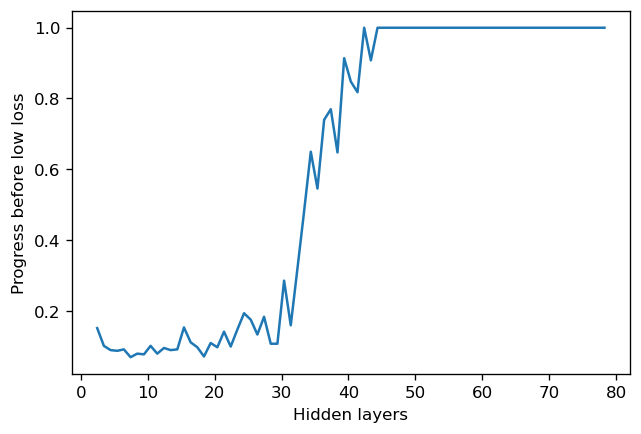

In [36]:
smooth = 10; plt.figure(dpi=120); plt.xlabel("Hidden layers"); plt.ylabel("Progress before low loss")
plt.plot(k1lib.smooth(data.hs, smooth), k1lib.smooth(data.ps, smooth));

So, vanilla network, with no help at all from smart architectures, can sustainably train at 30 hidden layers. After that, it's good as garbage.